In [1]:
import os
import glob
import segyio
import numpy as np
import pandas as pd
from scipy.signal import hilbert
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Load the datasets
unknown1 = pd.read_csv('unknown1_litho.csv')
unknown1.dropna(inplace = True)
unknown2 = pd.read_csv('unknown2_litho.csv')
unknown2.dropna(inplace = True)


In [3]:
unknown1 = unknown1[['Time (s)','Amplitude','Instantaneous_freq','Amplitude_abs','Amplitude_roll_mean','Amplitude_energy','Strat_Simplified_Viro_label']]
unknown2 = unknown2[['Time (s)','Amplitude','Instantaneous_freq','Amplitude_abs','Amplitude_roll_mean','Amplitude_energy','Strat_Simplified_Viro_label']]


In [4]:
# Folder path
folder_path = r'C:\Users\sushila\Desktop\Hackathon'

# Use glob to find all files that contain 'TEMP.csv' in the name
files = glob.glob(os.path.join(folder_path, '*RT.csv'))

# List to store data from each file
data_frames = []

# Loop through each file and read it
for file in files:
    # Extract the part of the filename before 'TEMP'
    file_name = os.path.basename(file)
    file_prefix = file_name.split('_RT')[0]
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the file prefix
    df['holeid'] = file_prefix
    
    # Append the DataFrame to the list
    data_frames.append(df)

# If you want to combine all the data into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

#Roundoff the depth so that it can be easily compared with depth from another dataframe
combined_data['Depth'] = combined_data['Depth'].round(1)
combined_data


,Time (s),Depth,RD,Amplitude,Instantaneous_freq,Amplitude_abs,Amplitude_roll_mean,Amplitude_energy,holeid
0,0.384,386.2,9.734242,-6140.7070,33.091248,6140.7070,1008.830078,37708284.0,LONCCARICA_1
1,0.388,390.4,9.183037,-10746.2380,30.999184,10746.2380,-1228.141797,115481640.0,LONCCARICA_1
2,0.392,394.3,8.123413,-9430.3750,220.216324,9430.3750,-4079.184766,88931976.0,LONCCARICA_1
3,0.396,398.3,33.520295,-2193.1113,28.288656,2193.1113,-5570.500000,4809737.5,LONCCARICA_1
4,0.400,402.6,32.489262,7895.1953,27.660295,7895.1953,-4123.047266,62334108.0,LONCCARICA_1
...,...,...,...,...,...,...,...,...,...
1717,1.736,3897.1,27.241943,6674.3280,28.629103,6674.3280,1859.277344,44546656.0,VIROVITICA_3ALFA
1718,1.740,3902.7,29.609911,3813.9023,27.492617,3813.9023,3098.795312,14545851.0,VIROVITICA_3ALFA
1719,1.744,3908.3,33.288143,-1668.5820,27.660799,1668.5820,3241.816406,2784166.0,VIROVITICA_3ALFA
1720,1.748,3914.5,47.818000,-7151.0625,28.908798,7151.0625,1477.887500,51137696.0,VIROVITICA_3ALFA


In [5]:
# Get the unique values in the 'holeid' column
unique_holeids = combined_data['holeid'].unique()

# Print the unique holeid values and their count
print(f"Number of unique holeid values: {len(unique_holeids)}")
print("Unique holeid values:")
print(unique_holeids)

Number of unique holeid values: 6
Unique holeid values:
['LONCCARICA_1' 'REZOVACCKE_KRCCEVINE_1' 'REZOVACCKE_KRCCEVINE_2'
 'SUHOPOLJE_1' 'VIROVITICA_1' 'VIROVITICA_3ALFA']


Number of exact depth matches: 198
Test RMSE: 8.0999


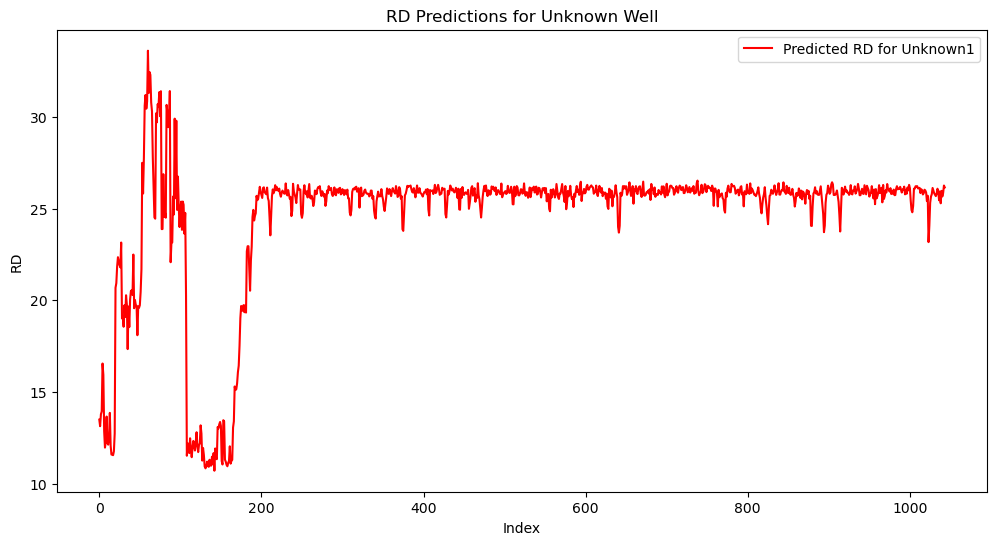

In [6]:
# Filter the dataset to include only the rows where holeid is either 'Lončarica-1' or 'Rezovačke Krčevine-1'
filtered_data_unknown1 = combined_data[combined_data['holeid'].isin(['LONCCARICA_1' ])]


litho_data = pd.read_csv('resampled_litho_data.csv')

# Sort both dataframes by 'holeid' and 'Depth'
combined_data = filtered_data_unknown1.sort_values(by=['holeid', 'Depth'])
litho_data = litho_data.sort_values(by=['holeid', 'Depth'])

# Merge the two dataframes on 'holeid' and 'Depth' to find exact matches
exact_match_data = pd.merge(combined_data, litho_data[['holeid', 'Depth', 'Lithology_label', 'Strat_Simplified_Viro_label']], 
                            on=['holeid', 'Depth'], how='inner')

# Check how many rows had exact depth matches
print(f"Number of exact depth matches: {exact_match_data.shape[0]}")


X = exact_match_data[['Time (s)','Amplitude','Instantaneous_freq', 'Amplitude_abs','Amplitude_roll_mean','Amplitude_energy','Strat_Simplified_Viro_label']]


# Target variable is 'PHI'
y = exact_match_data['RD']


# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



def grid_search(clf, param_grid, X_train, y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
#     print(grid.best_score_)
    
    return grid.best_estimator_


RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
RF_best = grid_search(RF, {}, X_train = X_train, y_train=y_train)
y_pred=RF_best.predict(X_test)

rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(f"Test RMSE: {rmse:.4f}")


X_unknown1_scaled = scaler.transform(unknown1)


# Predict using the best model
y_unknown1_pred = RF_best.predict(X_unknown1_scaled)  # Prediction for unknown1


# Plot the prediction for unknown1 alongside the true values
plt.figure(figsize=(12, 6))
plt.plot(y_unknown1_pred, label='Predicted RD for Unknown1', color='red')
plt.xlabel('Index')
plt.ylabel('RD')
plt.title('RD Predictions for Unknown Well')
plt.legend()
plt.show()

Number of exact depth matches: 95
Test RMSE: 9.3903


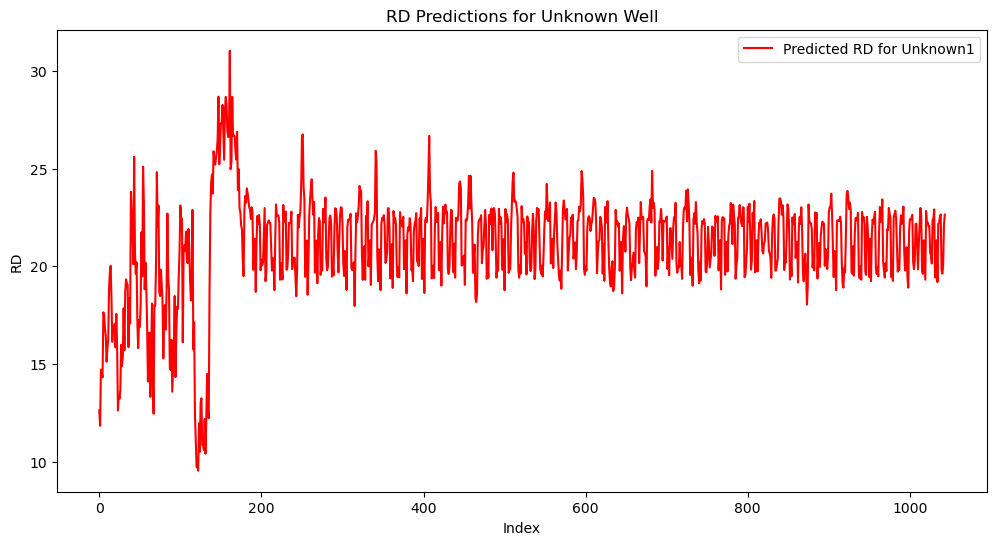

In [7]:
# Folder path
folder_path = r'C:\Users\sushila\Desktop\Hackathon'

# Use glob to find all files that contain 'TEMP.csv' in the name
files = glob.glob(os.path.join(folder_path, '*RT.csv'))

# List to store data from each file
data_frames = []

# Loop through each file and read it
for file in files:
    # Extract the part of the filename before 'TEMP'
    file_name = os.path.basename(file)
    file_prefix = file_name.split('_RT')[0]
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the file prefix
    df['holeid'] = file_prefix
    
    # Append the DataFrame to the list
    data_frames.append(df)

# If you want to combine all the data into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

#Roundoff the depth so that it can be easily compared with depth from another dataframe
combined_data['Depth'] = combined_data['Depth'].round(1)
combined_data

# Filter the dataset to include only the rows where holeid is either 'Lončarica-1' or 'Rezovačke Krčevine-1'
filtered_data_unknown1 = combined_data[combined_data['holeid'].isin(['VIROVITICA_1' ])]


litho_data = pd.read_csv('resampled_litho_data.csv')

# Sort both dataframes by 'holeid' and 'Depth'
combined_data = filtered_data_unknown1.sort_values(by=['holeid', 'Depth'])
litho_data = litho_data.sort_values(by=['holeid', 'Depth'])

# Merge the two dataframes on 'holeid' and 'Depth' to find exact matches
exact_match_data = pd.merge(combined_data, litho_data[['holeid', 'Depth', 'Lithology_label', 'Strat_Simplified_Viro_label']], 
                            on=['holeid', 'Depth'], how='inner')

# Check how many rows had exact depth matches
print(f"Number of exact depth matches: {exact_match_data.shape[0]}")


X = exact_match_data[['Time (s)','Amplitude','Instantaneous_freq', 'Amplitude_abs','Amplitude_roll_mean','Amplitude_energy','Strat_Simplified_Viro_label']]


# Target variable is 'PHI'
y = exact_match_data['RD']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



def grid_search(clf, param_grid, X_train, y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
#     print(grid.best_score_)
    
    return grid.best_estimator_


RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
RF_best = grid_search(RF, {}, X_train = X_train, y_train=y_train)
y_pred=RF_best.predict(X_test)

rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(f"Test RMSE: {rmse:.4f}")


X_unknown1_scaled = scaler.transform(unknown1)


# Predict using the best model
y_unknown1_pred1 = RF_best.predict(X_unknown1_scaled)  # Prediction for unknown1


# Plot the prediction for unknown1 alongside the true values
plt.figure(figsize=(12, 6))
plt.plot(y_unknown1_pred1, label='Predicted RD for Unknown1', color='red')
plt.xlabel('Index')
plt.ylabel('RD')
plt.title('RD Predictions for Unknown Well')
plt.legend()
plt.show()

Number of exact depth matches: 178
Test RMSE: 35.2774


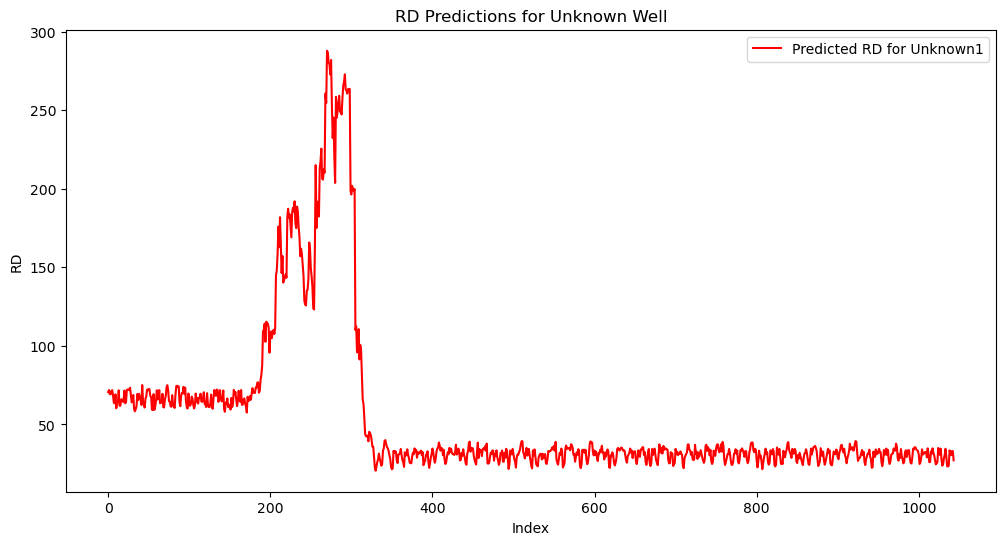

In [8]:
# Folder path
folder_path = r'C:\Users\sushila\Desktop\Hackathon'

# Use glob to find all files that contain 'TEMP.csv' in the name
files = glob.glob(os.path.join(folder_path, '*RT.csv'))

# List to store data from each file
data_frames = []

# Loop through each file and read it
for file in files:
    # Extract the part of the filename before 'TEMP'
    file_name = os.path.basename(file)
    file_prefix = file_name.split('_RT')[0]
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the file prefix
    df['holeid'] = file_prefix
    
    # Append the DataFrame to the list
    data_frames.append(df)

# If you want to combine all the data into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

#Roundoff the depth so that it can be easily compared with depth from another dataframe
combined_data['Depth'] = combined_data['Depth'].round(1)
combined_data

# Filter the dataset to include only the rows where holeid is either 'Lončarica-1' or 'Rezovačke Krčevine-1'
filtered_data_unknown1 = combined_data[combined_data['holeid'].isin(['VIROVITICA_3ALFA' ])]


litho_data = pd.read_csv('resampled_litho_data.csv')

# Sort both dataframes by 'holeid' and 'Depth'
combined_data = filtered_data_unknown1.sort_values(by=['holeid', 'Depth'])
litho_data = litho_data.sort_values(by=['holeid', 'Depth'])

# Merge the two dataframes on 'holeid' and 'Depth' to find exact matches
exact_match_data = pd.merge(combined_data, litho_data[['holeid', 'Depth', 'Lithology_label', 'Strat_Simplified_Viro_label']], 
                            on=['holeid', 'Depth'], how='inner')

# Check how many rows had exact depth matches
print(f"Number of exact depth matches: {exact_match_data.shape[0]}")


X = exact_match_data[['Time (s)','Amplitude','Instantaneous_freq', 'Amplitude_abs','Amplitude_roll_mean','Amplitude_energy','Strat_Simplified_Viro_label']]


# Target variable is 'PHI'
y = exact_match_data['RD']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



def grid_search(clf, param_grid, X_train, y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
#     print(grid.best_score_)
    
    return grid.best_estimator_


RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
RF_best = grid_search(RF, {}, X_train = X_train, y_train=y_train)
y_pred=RF_best.predict(X_test)

rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(f"Test RMSE: {rmse:.4f}")


X_unknown1_scaled = scaler.transform(unknown1)


# Predict using the best model
y_unknown1_pred2 = RF_best.predict(X_unknown1_scaled)  # Prediction for unknown1


# Plot the prediction for unknown1 alongside the true values
plt.figure(figsize=(12, 6))
plt.plot(y_unknown1_pred2, label='Predicted RD for Unknown1', color='red')
plt.xlabel('Index')
plt.ylabel('RD')
plt.title('RD Predictions for Unknown Well')
plt.legend()
plt.show()

In [9]:
# Average predicted RD using VIROVITICA_1 and LONCCARICA_1 is saved
unknown1 = pd.read_csv('unknown1_litho.csv')

unknown1['RD'] = (y_unknown1_pred + y_unknown1_pred1 + y_unknown1_pred2)/3

unknown1.to_csv('unknown1_litho.csv', index=False)



In [10]:
# For unknown 2

Number of exact depth matches: 299
Test RMSE: 13.2029


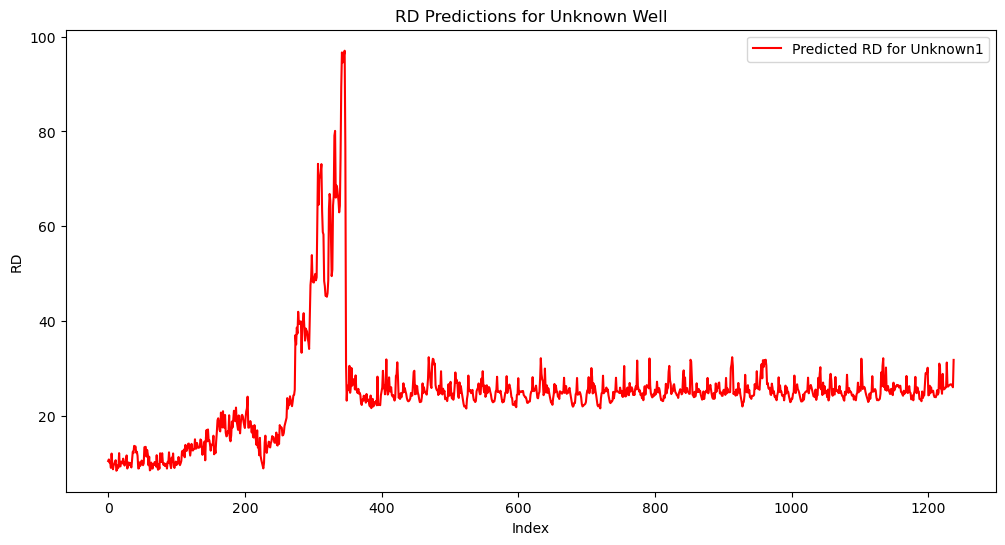

In [11]:
# Folder path
folder_path = r'C:\Users\sushila\Desktop\Hackathon'

# Use glob to find all files that contain 'TEMP.csv' in the name
files = glob.glob(os.path.join(folder_path, '*RT.csv'))

# List to store data from each file
data_frames = []

# Loop through each file and read it
for file in files:
    # Extract the part of the filename before 'TEMP'
    file_name = os.path.basename(file)
    file_prefix = file_name.split('_RT')[0]
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the file prefix
    df['holeid'] = file_prefix
    
    # Append the DataFrame to the list
    data_frames.append(df)

# If you want to combine all the data into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

#Roundoff the depth so that it can be easily compared with depth from another dataframe
combined_data['Depth'] = combined_data['Depth'].round(1)
combined_data

# Filter the dataset to include only the rows where holeid is either 'Lončarica-1' or 'Rezovačke Krčevine-1'
filtered_data_unknown1 = combined_data[combined_data['holeid'].isin(['REZOVACCKE_KRCCEVINE_1' ])]


litho_data = pd.read_csv('resampled_litho_data.csv')

# Sort both dataframes by 'holeid' and 'Depth'
combined_data = filtered_data_unknown1.sort_values(by=['holeid', 'Depth'])
litho_data = litho_data.sort_values(by=['holeid', 'Depth'])

# Merge the two dataframes on 'holeid' and 'Depth' to find exact matches
exact_match_data = pd.merge(combined_data, litho_data[['holeid', 'Depth', 'Lithology_label', 'Strat_Simplified_Viro_label']], 
                            on=['holeid', 'Depth'], how='inner')

# Check how many rows had exact depth matches
print(f"Number of exact depth matches: {exact_match_data.shape[0]}")


X = exact_match_data[['Time (s)','Amplitude','Instantaneous_freq', 'Amplitude_abs','Amplitude_roll_mean','Amplitude_energy','Strat_Simplified_Viro_label']]


# Target variable is 'PHI'
y = exact_match_data['RD']


# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



def grid_search(clf, param_grid, X_train, y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
#     print(grid.best_score_)
    
    return grid.best_estimator_


RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
RF_best = grid_search(RF, {}, X_train = X_train, y_train=y_train)
y_pred=RF_best.predict(X_test)

rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(f"Test RMSE: {rmse:.4f}")


X_unknown2_scaled = scaler.transform(unknown2)


# Predict using the best model
y_unknown2_pred = RF_best.predict(X_unknown2_scaled)  # Prediction for unknown1


# Plot the prediction for unknown1 alongside the true values
plt.figure(figsize=(12, 6))
plt.plot(y_unknown2_pred, label='Predicted RD for Unknown1', color='red')
plt.xlabel('Index')
plt.ylabel('RD')
plt.title('RD Predictions for Unknown Well')
plt.legend()
plt.show()

Number of exact depth matches: 263
Test RMSE: 8.4797


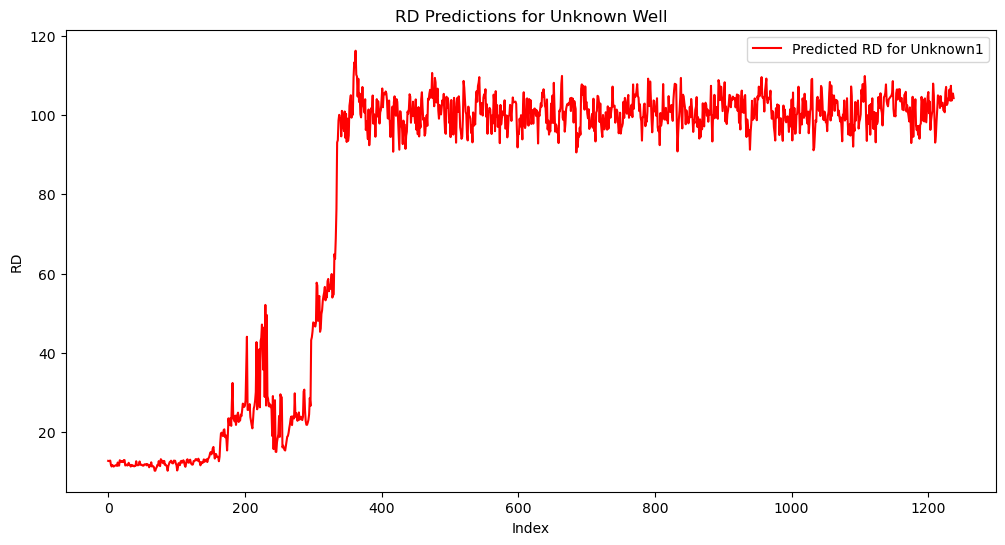

In [12]:

# Folder path
folder_path = r'C:\Users\sushila\Desktop\Hackathon'

# Use glob to find all files that contain 'TEMP.csv' in the name
files = glob.glob(os.path.join(folder_path, '*RT.csv'))

# List to store data from each file
data_frames = []

# Loop through each file and read it
for file in files:
    # Extract the part of the filename before 'TEMP'
    file_name = os.path.basename(file)
    file_prefix = file_name.split('_RT')[0]
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the file prefix
    df['holeid'] = file_prefix
    
    # Append the DataFrame to the list
    data_frames.append(df)

# If you want to combine all the data into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

#Roundoff the depth so that it can be easily compared with depth from another dataframe
combined_data['Depth'] = combined_data['Depth'].round(1)
combined_data

# Filter the dataset to include only the rows where holeid is either 'Lončarica-1' or 'Rezovačke Krčevine-1'
filtered_data_unknown1 = combined_data[combined_data['holeid'].isin([ 'REZOVACCKE_KRCCEVINE_2' ])]


litho_data = pd.read_csv('resampled_litho_data.csv')

# Sort both dataframes by 'holeid' and 'Depth'
combined_data = filtered_data_unknown1.sort_values(by=['holeid', 'Depth'])
litho_data = litho_data.sort_values(by=['holeid', 'Depth'])

# Merge the two dataframes on 'holeid' and 'Depth' to find exact matches
exact_match_data = pd.merge(combined_data, litho_data[['holeid', 'Depth', 'Lithology_label', 'Strat_Simplified_Viro_label']], 
                            on=['holeid', 'Depth'], how='inner')

# Check how many rows had exact depth matches
print(f"Number of exact depth matches: {exact_match_data.shape[0]}")


X = exact_match_data[['Time (s)','Amplitude','Instantaneous_freq', 'Amplitude_abs','Amplitude_roll_mean','Amplitude_energy','Strat_Simplified_Viro_label']]


# Target variable is 'PHI'
y = exact_match_data['RD']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



def grid_search(clf, param_grid, X_train, y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
#     print(grid.best_score_)
    
    return grid.best_estimator_


RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
RF_best = grid_search(RF, {}, X_train = X_train, y_train=y_train)
y_pred=RF_best.predict(X_test)

rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(f"Test RMSE: {rmse:.4f}")


X_unknown2_scaled = scaler.transform(unknown2)


# Predict using the best model
y_unknown2_pred1 = RF_best.predict(X_unknown2_scaled)  # Prediction for unknown1


# Plot the prediction for unknown1 alongside the true values
plt.figure(figsize=(12, 6))
plt.plot(y_unknown2_pred1, label='Predicted RD for Unknown1', color='red')
plt.xlabel('Index')
plt.ylabel('RD')
plt.title('RD Predictions for Unknown Well')
plt.legend()
plt.show()

Number of exact depth matches: 685
Test RMSE: 11.6500


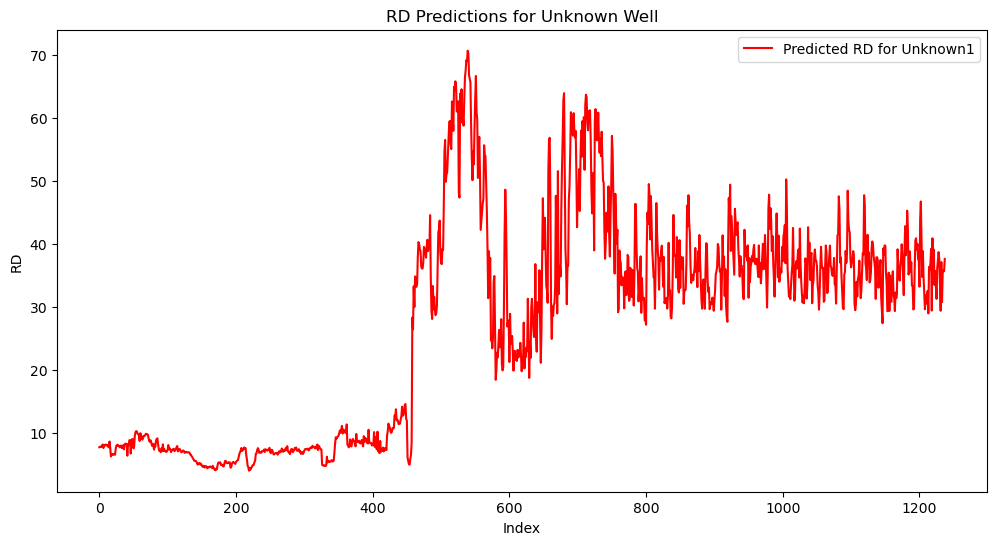

In [13]:

# Folder path
folder_path = r'C:\Users\sushila\Desktop\Hackathon'

# Use glob to find all files that contain 'TEMP.csv' in the name
files = glob.glob(os.path.join(folder_path, '*RT.csv'))

# List to store data from each file
data_frames = []

# Loop through each file and read it
for file in files:
    # Extract the part of the filename before 'TEMP'
    file_name = os.path.basename(file)
    file_prefix = file_name.split('_RT')[0]
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the file prefix
    df['holeid'] = file_prefix
    
    # Append the DataFrame to the list
    data_frames.append(df)

# If you want to combine all the data into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

#Roundoff the depth so that it can be easily compared with depth from another dataframe
combined_data['Depth'] = combined_data['Depth'].round(1)
combined_data

# Filter the dataset to include only the rows where holeid is either 'Lončarica-1' or 'Rezovačke Krčevine-1'
filtered_data_unknown1 = combined_data[combined_data['holeid'].isin([ 'SUHOPOLJE_1' ])]


litho_data = pd.read_csv('resampled_litho_data.csv')

# Sort both dataframes by 'holeid' and 'Depth'
combined_data = filtered_data_unknown1.sort_values(by=['holeid', 'Depth'])
litho_data = litho_data.sort_values(by=['holeid', 'Depth'])

# Merge the two dataframes on 'holeid' and 'Depth' to find exact matches
exact_match_data = pd.merge(combined_data, litho_data[['holeid', 'Depth', 'Lithology_label', 'Strat_Simplified_Viro_label']], 
                            on=['holeid', 'Depth'], how='inner')

# Check how many rows had exact depth matches
print(f"Number of exact depth matches: {exact_match_data.shape[0]}")


X = exact_match_data[['Time (s)','Amplitude','Instantaneous_freq', 'Amplitude_abs','Amplitude_roll_mean','Amplitude_energy','Strat_Simplified_Viro_label']]


# Target variable is 'PHI'
y = exact_match_data['RD']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



def grid_search(clf, param_grid, X_train, y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
#     print(grid.best_score_)
    
    return grid.best_estimator_


RF = RandomForestRegressor(n_estimators=100, random_state=100,n_jobs=-1)
RF_best = grid_search(RF, {}, X_train = X_train, y_train=y_train)
y_pred=RF_best.predict(X_test)

rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(f"Test RMSE: {rmse:.4f}")


X_unknown2_scaled = scaler.transform(unknown2)


# Predict using the best model
y_unknown2_pred2 = RF_best.predict(X_unknown2_scaled)  # Prediction for unknown1


# Plot the prediction for unknown1 alongside the true values
plt.figure(figsize=(12, 6))
plt.plot(y_unknown2_pred2, label='Predicted RD for Unknown1', color='red')
plt.xlabel('Index')
plt.ylabel('RD')
plt.title('RD Predictions for Unknown Well')
plt.legend()
plt.show()

In [14]:
y_avg2 = (y_unknown2_pred + y_unknown2_pred1 +y_unknown2_pred2 )/3


unknown2 = pd.read_csv('unknown2_litho.csv')




unknown2['RD'] = y_avg2


unknown2.to_csv('unknown2_litho.csv', index=False)
